# Importing libraries



In [6]:
# Install using pip
!pip install transformers seqeval[gpu]
!pip install sentencepiece
!pip install sentencepiec

# Import libraries
import re
import spacy
from spacy.tokens import Span
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification, AdamW
from nltk.corpus import wordnet as wn
import nltk
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from transformers import RobertaForTokenClassification, RobertaTokenizer
from transformers import DistilBertTokenizer, TFDistilBertForTokenClassification
from transformers import XLNetTokenizer, XLNetForTokenClassification
from seqeval.metrics import f1_score, accuracy_score
from nltk.corpus import wordnet
from collections import OrderedDict
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

sp = spacy.load('en_core_web_sm')

# Select device
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sentencepiec (from versions: none)
ERROR: No matching distribution found for sentencepiec


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Importing data

In [84]:
# File must be semi-colon separated. Expected columns:
#      question -> contains geo-analytical questions
#      type     -> contains 'Train' or 'Test'
# Important: 'Train' data must be on top and 'Test' data must follow
questions = pd.read_csv("data/questions.csv", sep=";").dropna()

# File must be semi-colon separated. Expected columns:
#      phrase   -> contains phrase to be categorised
#      tag      -> contains category
dictionary = pd.read_csv("data/dictionary.csv", sep=";").dropna()

# Data augmentation

In [85]:
def find_synonyms(word):
  synonyms = []
  for synset in wordnet.synsets(word, pos=wn.NOUN):
    for syn in synset.lemma_names():
      synonyms.append(syn.replace("_", " "))

  # using this to drop duplicates while maintaining word order (closest synonyms comes first)
  synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
  return synonyms_without_duplicates

In [86]:
dictionary["synonyms"] = ""
for index, cc_tags in dictionary.iterrows():
  dictionary.loc[index, "synonyms"] = find_synonyms(cc_tags["phrase"])

In [87]:
# Set words that should not be tagged
# This makes sure word 'states' in 'United States' is not tagged
cc_excluded_phrases = ["United States", "Tarrant County", "Ferry Building", "Twin Peaks", "New York City", "Loudoun County"]

# Checks if found occurrence is inside excluded phrase
def should_exclude(input_question_text, cc_occurrence):
  for cc_excluded_phrase in cc_excluded_phrases:
    for cc_excluded_phrase_occurrence in re.finditer(cc_excluded_phrase.lower().strip(), input_question_text.lower().strip()):
      if cc_excluded_phrase_occurrence.start() <= cc_occurrence.start() and cc_excluded_phrase_occurrence.end() >= cc_occurrence.end():
        return True
  return False

In [88]:
augmented_sentences = []

# Loop through train questions only
for index1, input_question in questions[questions["type"] == "Train"].iterrows():
  input_question_text = input_question["question"]

  # Loop through all core concepts
  for index2, cc_tags in dictionary.iterrows():
    for cc_occurrence in re.finditer(cc_tags["phrase"].lower().strip(), input_question_text.lower().strip()):

      # Skip if found occurrence is inside excluded phrase (we shouldn't add synonyms here)
      if should_exclude(input_question_text, cc_occurrence):
        continue
      
      for synonym in cc_tags["synonyms"]:
        augmented_sentences.append([(input_question_text[0:cc_occurrence.start()] + synonym + input_question_text[cc_occurrence.end():len(input_question_text)]).strip(), "Train"])

# Set augmented sentence list to df
augmented_sentences_df = pd.DataFrame(augmented_sentences, columns=["question", "type"])

# Append augmented sentences to original train questions
augmented_sentences_df = questions[questions["type"] == "Train"].append(augmented_sentences_df, ignore_index=True)

# Append test questions to bottom
questions = augmented_sentences_df.append(questions[questions["type"] == "Test"], ignore_index=True)

# Drop duplicates
questions = questions.drop_duplicates(subset=['question'], ignore_index=True)

In [89]:
# Information about which synonym belonged to which phrase had to be preserved
# for augmenting sentences, but now that's done dictionary can be replaced with
# all synonyms and their tags
new_dictionary = []
for idx,xs in dictionary.iterrows():
  new_dictionary.append([xs["phrase"], xs["tag"]])
  for x in xs["synonyms"]:
    new_dictionary.append([x, xs["tag"]])

dictionary = pd.DataFrame(new_dictionary, columns=["phrase", "tag"])
dictionary = dictionary.drop_duplicates(subset=['phrase'], ignore_index=True)

# Data pre-processing

In [93]:
print(len(questions[questions["type"] == "Train"]))
print(len(dictionary))

4180
1199


In [94]:
# Sort input on length (descending) to make sure longest phrases are tagged first
dictionary["length"] = dictionary["phrase"].str.len()
dictionary.sort_values("length", ascending=False, inplace=True)

# Create empty list
data = []

# Loop through all questions from question corpus
for index1, input_question in questions.iterrows():
  input_question_text = input_question["question"]

  # Get results from SpaCy
  pos_result = sp(input_question_text)

  # SpaCy creates default IOB tags, these are removed
  pos_result.ents = []

  # Loop through all core concepts
  for index2, cc_tags in dictionary.iterrows():
    for cc_occurrence in re.finditer(cc_tags["phrase"].lower().strip(), input_question_text.lower().strip()):

      # Skip if found occurrence is inside excluded phrase
      if should_exclude(input_question_text, cc_occurrence):
        continue

      # Add found result to ents if valid result
      if pos_result.char_span(cc_occurrence.start(), cc_occurrence.end(), label=cc_tags["tag"]) is not None:
        try:
          pos_result.ents = list(pos_result.ents) + [pos_result.char_span(cc_occurrence.start(), cc_occurrence.end(), label=cc_tags["tag"])]
        except:
          pass
          
  # Loop through all words and add results to list
  for word in pos_result:
    data.append([index1, word.text, word.pos_, "-".join(x for x in [word.ent_iob_, word.ent_type_] if x), input_question_text, input_question["type"]])

result = pd.DataFrame(data, columns=["sentence_number", "word", "word_pos", "word_tag", "sentence", "type"])

In [95]:
result[result["type"] == "Train"]['word_tag'].value_counts()

O           46041
B-OBJ        5655
I-OBJ        2869
B-EVE        1670
B-CNAC        779
I-CVAL        775
B-PROPIR      655
B-CVAL        645
B-NETQR       608
I-NETQR       608
I-EVE         477
B-EVEQO       340
I-CNAC        296
B-FLDR        252
I-OBJQB       244
B-OBJQB       244
I-FLDR        230
B-FLDN        212
I-FLDN        210
B-CNAER       181
I-PROPIR      169
B-NET         124
I-OBJQR       123
B-OBJQI       119
B-OBJQR       112
B-CVAER       109
I-OBJQI        57
I-CNAER        37
B-FLDI         27
B-FLDO         21
I-CVAER        18
I-EVEQO        17
B-EVEQR         9
I-FLDO          7
B-OBJQN         6
I-OBJQN         6
I-NET           3
I-FLDI          3
I-EVEQR         1
Name: word_tag, dtype: int64

In [96]:
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                       s["word_pos"].values.tolist(),
                                                       s["word_tag"].values.tolist())]
    self.grouped = self.data.groupby("sentence_number").apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None

getter = SentenceGetter(result)

# Set sentence and labels to list
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]

# Add PAD tag and create id's of tags
tag_values = list(set(result["word_tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

# BERT fine-tuning

In [97]:
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

tokenizer = None
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [98]:
def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []

  for word, label in zip(sentence, text_labels):

    # Tokenize the word and count # of subwords the word is broken into
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)

    # Add the tokenized word to the final tokenized word list
    tokenized_sentence.extend(tokenized_word)

    # Add the same label to the new list of labels `n_subwords` times
    labels.extend([label] * n_subwords)

  return tokenized_sentence, labels

tokenized_texts_and_labels = [
  tokenize_and_preserve_labels(sent, labs)
  for sent, labs in zip(sentences, labels)
]

# Tokenized texts and corresponding tags
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

# Maximum length of phrase is set to longest sentence
MAX_LEN = max([len(x) for x in tokenized_texts])
bs = 16

In [99]:
# PAD sentences up to maximum length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

# Set tags for padded parts
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

# Create attention mask (1 = actual words, 0 = PAD)
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Create tensors for training data (first n'th sentences)
tr_inputs = torch.tensor(input_ids[0:questions["type"].value_counts()[0]])
tr_tags = torch.tensor(tags[0:questions["type"].value_counts()[0]])
tr_masks = torch.tensor(attention_masks[0:questions["type"].value_counts()[0]])

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Create tensors for test data (last n'th sentences)
val_inputs = torch.tensor(input_ids[questions["type"].value_counts()[0]:questions.shape[0]])
val_tags = torch.tensor(tags[questions["type"].value_counts()[0]:questions.shape[0]])
val_masks = torch.tensor(attention_masks[questions["type"].value_counts()[0]:questions.shape[0]])

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [100]:
model = None
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.cuda();

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [101]:
# Set Adam parameters
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [102]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [103]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print(pred_tags)
    print(valid_tags)

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.19728523816643212


Epoch:  33%|███▎      | 1/3 [00:26<00:53, 26.88s/it]

Validation loss: 0.2700747590925958
['O', 'O', 'O', 'B-FLDR', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'B-NET', 'O', 'B-OBJ', 'O', 'O', 'O', 'B-OBJ', 'I-FLDN', 'O', 'O', 'B-FLDN', 'O', 'B-FLDN', 'I-FLDN', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'O', 'B-FLDN', 'B-FLDN', 'B-PROPIR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'O', 'O', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'O', 'B-OBJ', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'B-EVE', 'O', 'B-NETQR', 'I-NETQR', 'O', 'O', 'B-EVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'O', 'B-EVE', 'O', 'O', 'O', 'B-EVE', 'O',

Epoch:  67%|██████▋   | 2/3 [00:52<00:26, 26.35s/it]

Validation loss: 0.23506907001137733
['O', 'O', 'O', 'B-FLDR', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'B-NET', 'O', 'B-OBJ', 'O', 'O', 'O', 'B-NET', 'I-FLDN', 'O', 'O', 'B-FLDN', 'O', 'B-FLDN', 'I-FLDN', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'O', 'B-FLDN', 'B-FLDN', 'I-PROPIR', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'B-NET', 'O', 'B-NET', 'O', 'O', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'B-EVE', 'O', 'B-NETQR', 'I-NETQR', 'O', 'O', 'B-EVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'O', 'B-EVE',

Epoch: 100%|██████████| 3/3 [01:18<00:00, 26.27s/it]

Validation loss: 0.26395248373349506
['O', 'O', 'O', 'B-FLDR', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'I-FLDR', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'B-NET', 'O', 'B-OBJ', 'O', 'O', 'O', 'B-NET', 'B-NET', 'O', 'O', 'B-FLDN', 'O', 'B-FLDN', 'I-FLDN', 'O', 'O', 'O', 'O', 'O', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'B-FLDR', 'O', 'B-FLDN', 'B-FLDN', 'I-PROPIR', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NET', 'O', 'O', 'B-OBJ', 'I-OBJ', 'I-OBJ', 'I-OBJ', 'O', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'B-OBJ', 'B-OBJ', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-OBJ', 'I-OBJ', 'O', 'O', 'B-EVE', 'O', 'B-NETQR', 'I-NETQR', 'O', 'O', 'B-EVE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'O', 'B-EVE', 'O', 'O', 'O', 'B-EV

# Evaluation

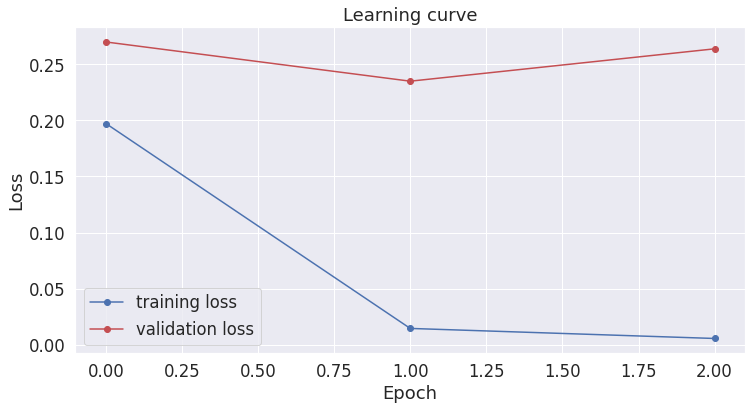

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [105]:
test_sentences = questions[questions["type"] == "Test"]["question"]

bert_data = []
confusion_matrix = []

for test_sentence in test_sentences:
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
      new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
      new_labels.append(tag_values[label_idx])
      new_tokens.append(token)

  for token, label in zip(new_tokens, new_labels):
    bert_data.append([label, token])
  
  bert_result = pd.DataFrame(bert_data)
  bert_result.columns = ["label", "token"]
  bert_result = bert_result[(bert_result["token"] != "[CLS]") & (bert_result["token"] != "[SEP]")]
  
  merged_result = pd.merge(bert_result, result[result["sentence_number"] == questions[questions["question"] == test_sentence].index[0]], left_on = 'token', right_on = 'word')

  for index2, answer in merged_result.iterrows():
    if not [x for x in confusion_matrix if x[0] == answer["label"]]:
      confusion_matrix.append([answer["label"], 0, 0, 0])
    if not [x for x in confusion_matrix if x[0] == answer["word_tag"]]:
      confusion_matrix.append([answer["word_tag"], 0, 0, 0])
    
    for i in confusion_matrix:
      if i[0] == answer["label"]:
        # True Positive
        if answer["label"] == answer["word_tag"]:
          i[3] += 1
        
        # False Positive
        if answer["label"] != answer["word_tag"]:
          i[1] += 1
      
      if i[0] == answer["word_tag"]:
        # False Negative
        if answer["word_tag"] != answer["label"]:
          i[2] += 1

confusion_matrix_pd = pd.DataFrame(confusion_matrix, columns=["tag", "False Positive", "False Negative", "True Positive"])

In [106]:
confusion_matrix_pd["Precision"] = "N/A"
confusion_matrix_pd["Recall"] = "N/A"
confusion_matrix_pd["F1-score"] = "N/A"

for index, row in confusion_matrix_pd.iterrows():
  # Calculate Precision
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "Precision"] = row["True Positive"] / (row["True Positive"] + row["False Positive"])

  # Calculate Recall
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "Recall"] = row["True Positive"] / (row["True Positive"] + row["False Negative"])

  # Calculate F1-score
  if row["True Positive"] != 0:
    confusion_matrix_pd.loc[index, "F1-score"] = 2 * (confusion_matrix_pd.loc[index, "Precision"] * confusion_matrix_pd.loc[index, "Recall"]) / (confusion_matrix_pd.loc[index, "Precision"] + confusion_matrix_pd.loc[index, "Recall"])


confusion_matrix_pd.sort_values(by=['tag'], inplace=True)
confusion_matrix_pd

,tag,False Positive,False Negative,True Positive,Precision,Recall,F1-score
12,B-CNAC,7,7,82,0.921348,0.921348,0.921348
20,B-CNAER,12,11,3,0.2,0.214286,0.206897
19,B-CVAER,3,94,1,0.25,0.010526,0.020202
22,B-CVAL,8,4,39,0.829787,0.906977,0.866667
9,B-EVE,27,20,83,0.754545,0.805825,0.779343
25,B-EVEQR,0,4,0,N/A,N/A,N/A
30,B-FLDI,0,1,0,N/A,N/A,N/A
5,B-FLDN,11,17,8,0.421053,0.32,0.363636
24,B-FLDO,1,0,0,N/A,N/A,N/A
1,B-FLDR,1,34,16,0.941176,0.32,0.477612
